In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install anesthetic
import os
os.chdir("/content/drive/MyDrive/project")

In [3]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as dists
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, multivariate_normal
from anesthetic.plot import kde_plot_1d, kde_contour_plot_2d
from torch_utils import get_limits, visualise_tension, visualise_coordinate, plot_marginalised_dists, TrainUtil
from np_utils import simple_data, curved_data, uniform_prior_samples
from tension_net import TensionNet, TensionNet1
from tension_quantify import BayesFactor, SuspiciousnessKLDiv, LogSuspiciousness

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
X0, X1, X_prior = simple_data()
X0_tensor = torch.tensor(X0).float().to(device)
X1_tensor = torch.tensor(X1).float().to(device)
X_prior_tensor = torch.tensor(X_prior).float().to(device)

(<matplotlib.tri.tricontour.TriContourSet at 0x7fc638a21908>,
 <matplotlib.tri.tricontour.TriContourSet at 0x7fc6389d9710>)

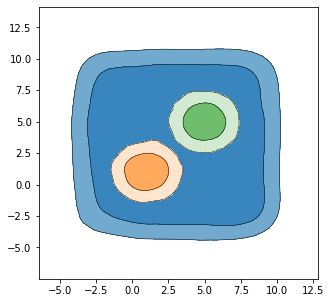

In [6]:
fig, axs = plt.subplots(figsize=(5, 5))

kde_contour_plot_2d(axs, X_prior[:, 0], X_prior[:, 1])
kde_contour_plot_2d(axs, X0[:, 0], X0[:, 1])
kde_contour_plot_2d(axs, X1[:, 0], X1[:, 1])

In [7]:
lrs = torch.pow(10, torch.arange(-10, 1).float())

In [8]:
tension_R = TensionNet1(2)
criterion = BayesFactor(hist_type="gaussian", hist_param=1, n_dist_bins=100, 
                        n_prior_bins=50)
optimizer = optim.SGD(tension_R.parameters(), lr=0.0005)
train_util_R = TrainUtil(tension_R, optimizer, criterion, device, animation=False)

for lr in lrs:
    train_util_R.optimizer = optim.SGD(train_util_R.net.parameters(), lr=lr)
    losses_R = train_util_R.train(X0, X1, X_prior, n_iter=(30 if lr.item() != 1 else 100))

In [9]:
tension_S = TensionNet1(2)
criterion = SuspiciousnessKLDiv(hist_type="gaussian", hist_param=1,
                                n_dist_bins=100, n_prior_bins=50)

optimizer = optim.SGD(tension_S.parameters(), lr=0.0005)
train_util_S = TrainUtil(tension_S, optimizer, criterion, device, animation=False)

for lr in lrs:
    train_util_S.optimizer = optim.SGD(train_util_S.net.parameters(), lr=lr)
    losses_S = train_util_S.train(X0, X1, X_prior, n_iter=(30 if lr.item() != 1 else 100))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2398: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


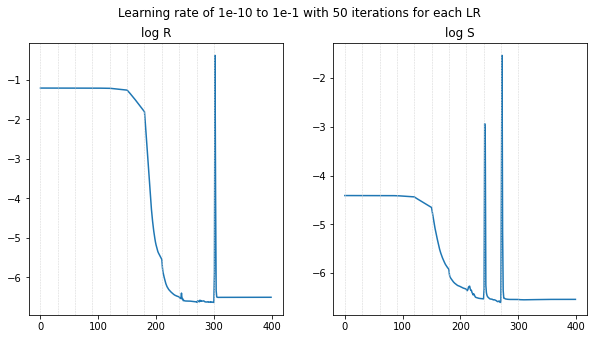

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Learning rate of 1e-10 to 1e-1 with 50 iterations for each LR")
train_util_R.plot_loss(axs[0])
train_util_S.plot_loss(axs[1])
axs[0].set_title("log R")
axs[1].set_title("log S")

for i in range(11):
    axs[0].axvline(30 * i, color='lightgrey', linestyle='--', lw=0.5)
    axs[1].axvline(30 * i, color='lightgrey', linestyle='--', lw=0.5)

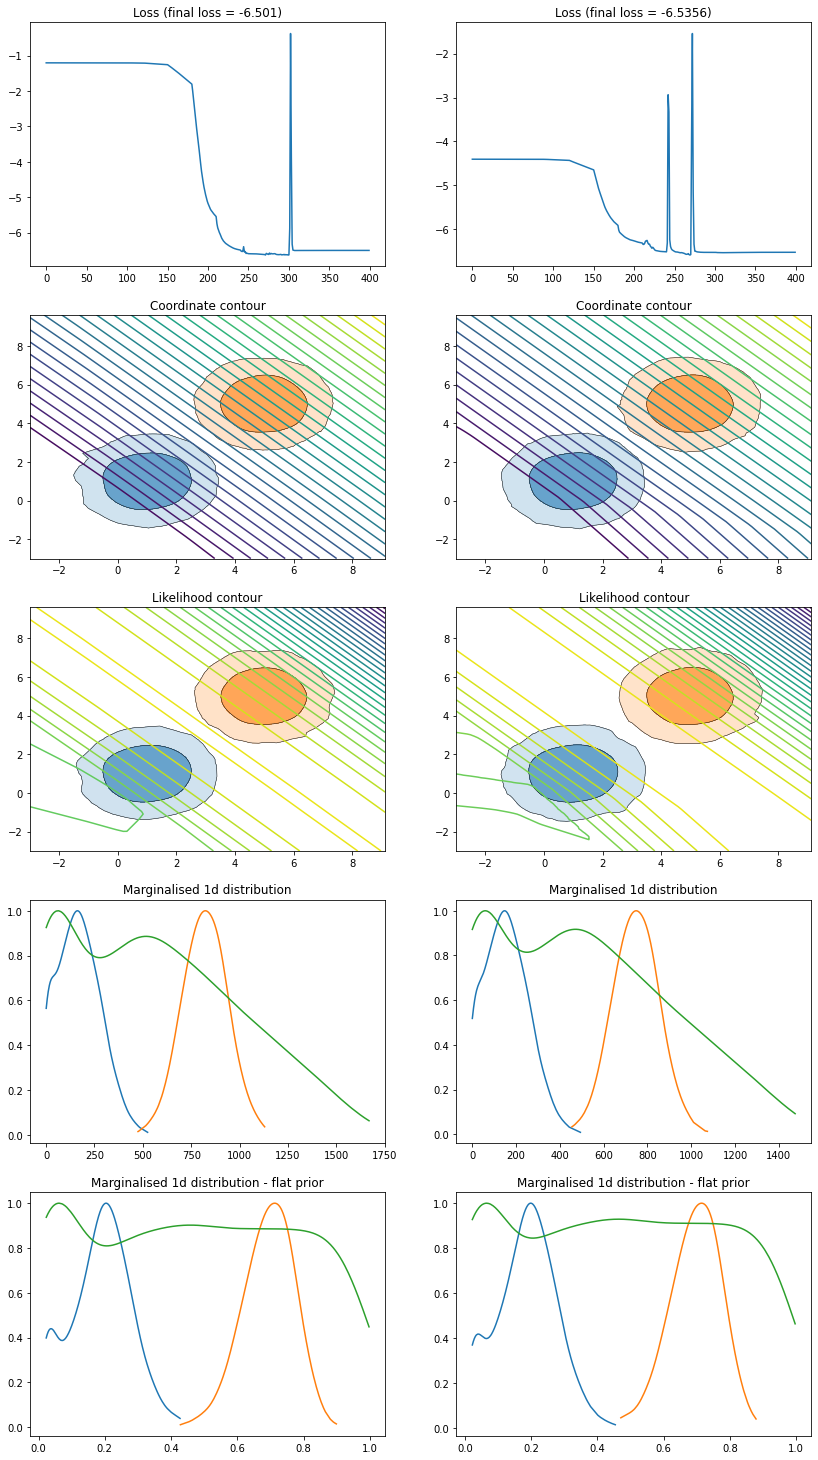

In [11]:
fig, axs = plt.subplots(5, 2, figsize=(14, 26))

train_util_R.plot_loss(axs[0, 0])
train_util_R.visualise_coordinate(axs[1, 0])
train_util_R.visualise_tension(axs[2, 0])
train_util_R.plot_marginalised_dists(axs[3, 0])
train_util_R.plot_marginalised_dists(axs[4, 0], flat_prior=True)

train_util_S.plot_loss(axs[0, 1])
train_util_S.visualise_coordinate(axs[1, 1])
train_util_S.visualise_tension(axs[2, 1])
train_util_S.plot_marginalised_dists(axs[3, 1])
train_util_S.plot_marginalised_dists(axs[4, 1], flat_prior=True)

In [12]:
X0_c, X1_c, X_prior_c = curved_data()
X0_c_tensor = torch.tensor(X0_c).float().to(device)
X1_c_tensor = torch.tensor(X1_c).float().to(device)
X_prior_c_tensor = torch.tensor(X_prior_c).float().to(device)

(<matplotlib.tri.tricontour.TriContourSet at 0x7fc5d6c92128>,
 <matplotlib.tri.tricontour.TriContourSet at 0x7fc638a86e10>)

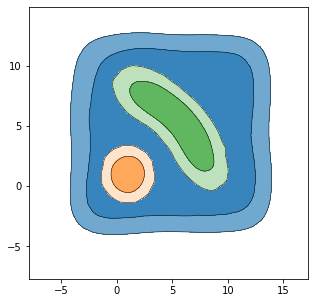

In [13]:
fig, axs = plt.subplots(figsize=(5, 5))

kde_contour_plot_2d(axs, X_prior_c[:, 0], X_prior_c[:, 1])
kde_contour_plot_2d(axs, X0_c[:, 0], X0_c[:, 1])
kde_contour_plot_2d(axs, X1_c[:, 0], X1_c[:, 1])

In [18]:
tension_R_c = TensionNet1(2)
criterion = BayesFactor(hist_type="gaussian", hist_param=1, n_dist_bins=100, 
                        n_prior_bins=50)
optimizer = optim.SGD(tension_R_c.parameters(), lr=0.0005)
train_util_R_c = TrainUtil(tension_R_c, optimizer, criterion, device, animation=False)

for lr in lrs:
    train_util_R_c.optimizer = optim.SGD(train_util_R_c.net.parameters(), lr=lr)
    losses_R_c = train_util_R_c.train(X0, X1, X_prior, n_iter=(30 if lr.item() != 1 else 100))

In [24]:
tension_S_c = TensionNet1(2)
criterion = SuspiciousnessKLDiv(hist_type="gaussian", hist_param=1,
                                n_dist_bins=100, n_prior_bins=50)

optimizer = optim.SGD(tension_S_c.parameters(), lr=0.0005)
train_util_S_c = TrainUtil(tension_S_c, optimizer, criterion, device, animation=False)

for lr in lrs:
    train_util_S_c.optimizer = optim.SGD(train_util_S_c.net.parameters(), lr=lr)
    losses_S_c = train_util_S_c.train(X0, X1, X_prior, n_iter=(30 if lr.item() != 1 else 100))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2398: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


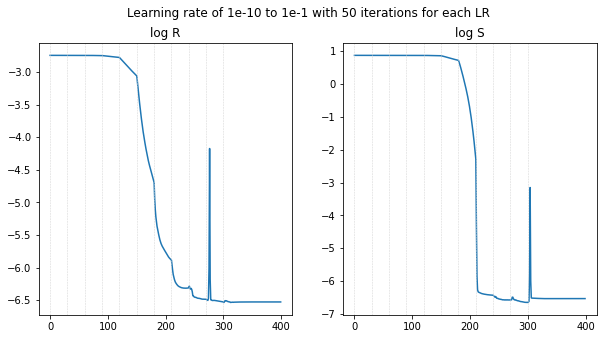

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Learning rate of 1e-10 to 1e-1 with 50 iterations for each LR")
train_util_R_c.plot_loss(axs[0])
train_util_S_c.plot_loss(axs[1])
axs[0].set_title("log R")
axs[1].set_title("log S")

for i in range(11):
    axs[0].axvline(30 * i, color='lightgrey', linestyle='--', lw=0.5)
    axs[1].axvline(30 * i, color='lightgrey', linestyle='--', lw=0.5)

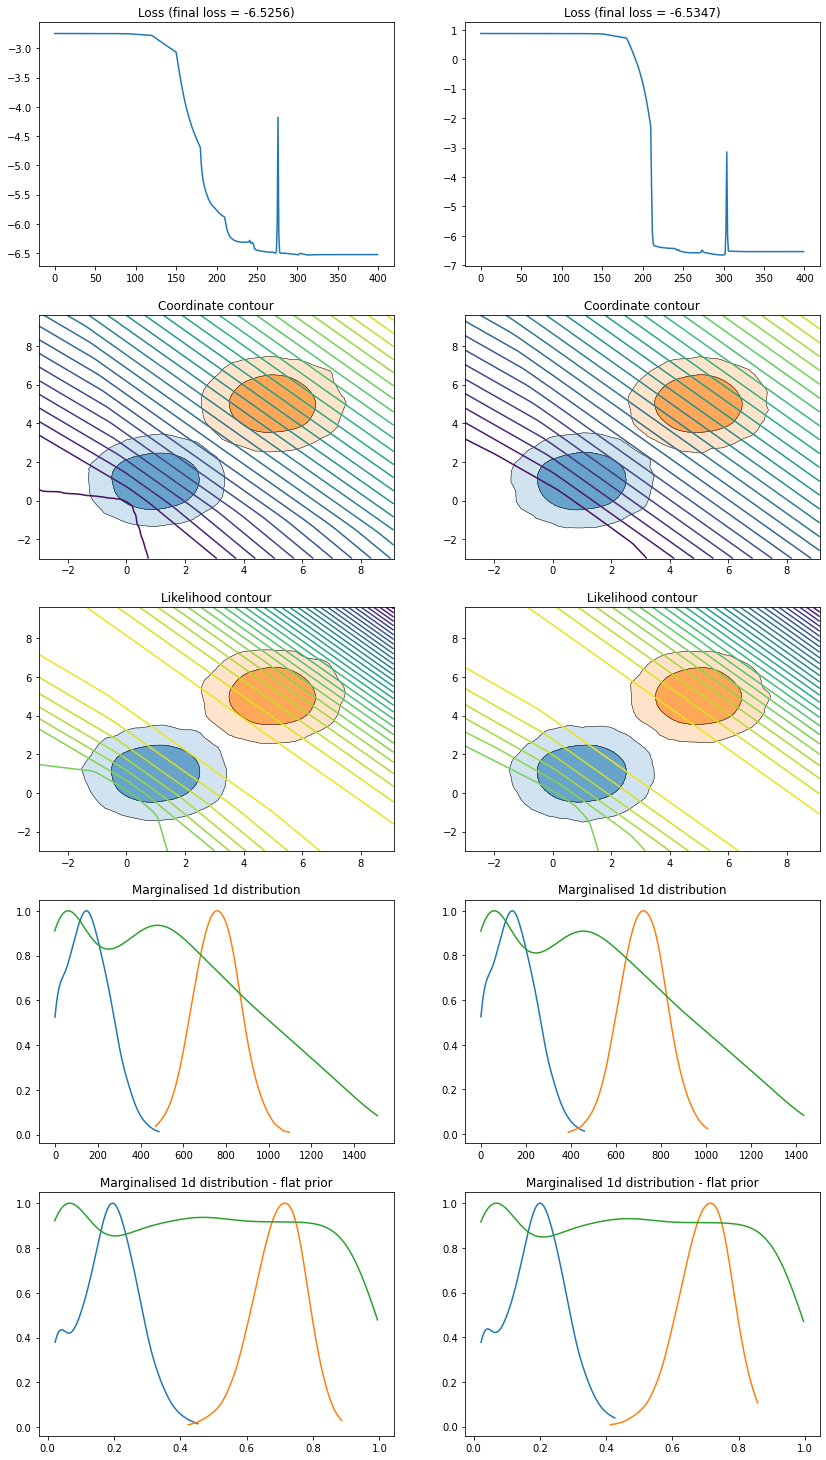

In [26]:
fig, axs = plt.subplots(5, 2, figsize=(14, 26))

train_util_R_c.plot_loss(axs[0, 0])
train_util_R_c.visualise_coordinate(axs[1, 0])
train_util_R_c.visualise_tension(axs[2, 0])
train_util_R_c.plot_marginalised_dists(axs[3, 0])
train_util_R_c.plot_marginalised_dists(axs[4, 0], flat_prior=True)

train_util_S_c.plot_loss(axs[0, 1])
train_util_S_c.visualise_coordinate(axs[1, 1])
train_util_S_c.visualise_tension(axs[2, 1])
train_util_S_c.plot_marginalised_dists(axs[3, 1])
train_util_S_c.plot_marginalised_dists(axs[4, 1], flat_prior=True)

### From both learning rate plots, clear that a learning rate of around 10^-3 to 10^-4 is ideal in terms of learning quickly.